# หัดใช้ Autoencoders ทำ Anomaly detection บนภาพ

เอกสารประกอบ
- https://www.kaggle.com/code/shivamb/how-autoencoders-work-intro-and-usecases

In [1]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model

from random import randint
import pandas as pd
import numpy as np

In [2]:
import os
from tqdm import tqdm
import cv2  
import numpy as np

from PIL import Image 

def load_data(foloder,class_names):
    """
        Load the data:
    """
    
    class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

    nb_classes = len(class_names)

    IMAGE_SIZE = (28, 28)
    
    
    
    datasets = [foloder]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            if('.DS_Store' in folder):
                continue
                
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):    
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        #images = np.array(images, dtype = 'float32')
        images = np.array(images, dtype = 'int')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append([images, labels])

    return output

In [3]:
class_names = ['circles', 'squares','triangles']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

output = load_data('images',class_names = ['circles', 'squares','triangles'])

100%|██████████| 100/100 [00:00<00:00, 3967.63it/s]

Loading images


In [4]:
data,label = output[0]

In [5]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(data, label, random_state=22)
train_images = train_images/255
train_images = np.dot(train_images[...,:3], [0.299, 0.587, 0.114])

In [6]:
def preview_examples(class_names, images, labels,maxdisplay=25):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Examples of images of the dataset", fontsize=16)
    for i in range(maxdisplay):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [7]:
train_images = train_images - 1

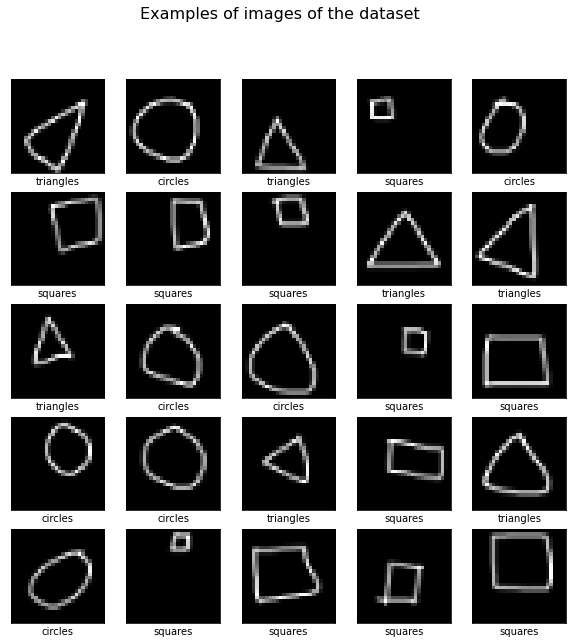

In [8]:
preview_examples(class_names,train_images,train_labels)

In [9]:
train_images[0]

array([[-1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16],
       [-1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11022302e-16, -1.11022302e-16,
        -1.11022302e-16, -1.11

In [10]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1177500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              501000

In [12]:
#28*28
train_x = train_images.reshape(-1, 784)

In [13]:
model.compile(optimizer='adam', loss='mse')
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=100, batch_size=50,
          #validation_data=(val_x, val_x),
          #callbacks=[early_stopping]
         )

Epoch 1/100
6/6 [==============================] - 2s 105ms/step - loss: 0.0247
Epoch 2/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0232
Epoch 3/100
6/6 [==============================] - 0s 66ms/step - loss: 0.0230
Epoch 4/100
6/6 [==============================] - 1s 122ms/step - loss: 0.0228
Epoch 5/100
6/6 [==============================] - 0s 59ms/step - loss: 0.0227
Epoch 6/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0226
Epoch 7/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0224
Epoch 8/100
6/6 [==============================] - 0s 73ms/step - loss: 0.0220
Epoch 9/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0214
Epoch 10/100
6/6 [==============================] - 1s 126ms/step - loss: 0.0210
Epoch 11/100
6/6 [==============================] - 0s 60ms/step - loss: 0.0205
Epoch 12/100
6/6 [==============================] - 0s 76ms/step - loss: 0.0200
Epoch 13/100
6/6 [============================

#### ทดสอบดึงค่าที่ผิดปกติ

In [21]:
class_names = ['anomaly']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

class_names_label

{'anomaly': 0}

In [15]:
class_names = ['anomaly']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

output = load_data('images_test',class_names = ['anomaly'])

Loading images_test


100%|██████████| 8/8 [00:00<00:00, 2413.99it/s]


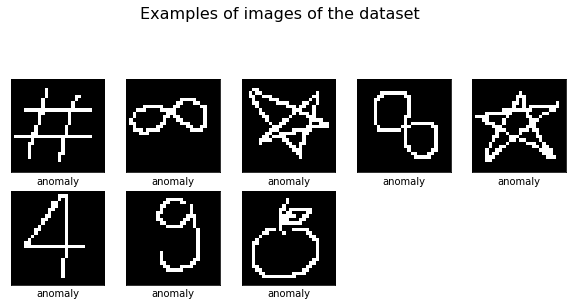

In [16]:
datatest,label = output[0]
datatest = datatest/255
datatest = np.dot(datatest[...,:3], [0.299, 0.587, 0.114])
datatest = datatest - 1
#28*28
val_x = datatest.reshape(-1, 784)

preview_examples(class_names,datatest,label,maxdisplay=8)

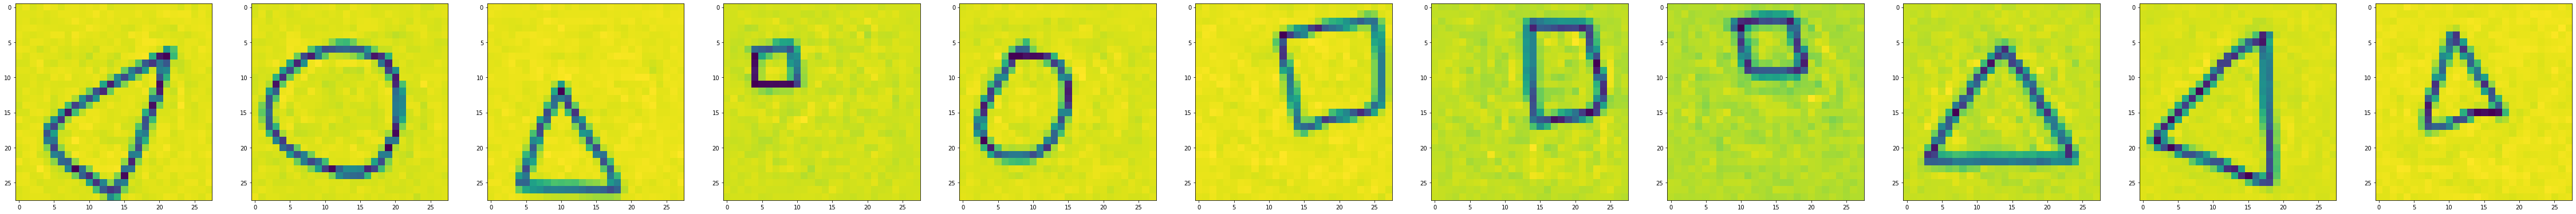

In [17]:
#ตัวอย่าง train 
predsTrain = model.predict(train_x)
f, ax = plt.subplots(1,11)
f.set_size_inches(80, 40)
for i in range(11):
    ax[i].imshow(predsTrain[i].reshape(28, 28))

In [18]:
predsTrain.mean() , predsTrain.std() , predsTrain.mean() + predsTrain.std()

(-0.053941566, 0.15518507, 0.10124351)

#### ทดสอบกับค่าที่ผิดปกติ ค่า mean กับ std จะหลุดออกไปไกล

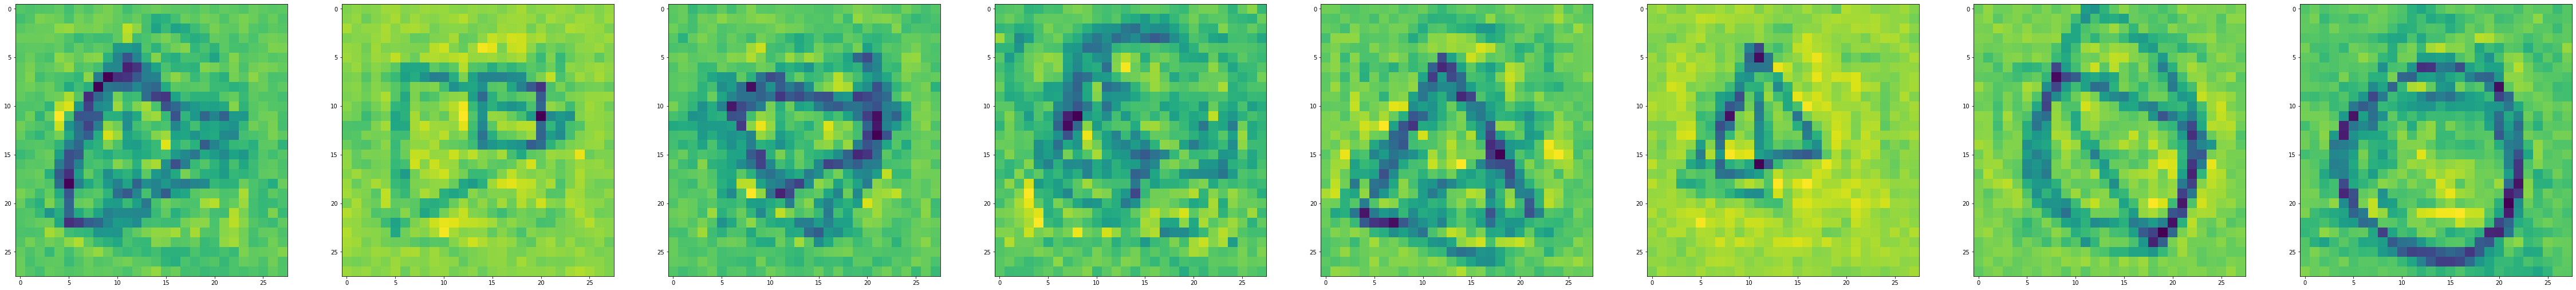

In [19]:
predsTest = model.predict(val_x)
f, ax = plt.subplots(1,8)
f.set_size_inches(80, 40)
for i in range(8):
    ax[i].imshow(predsTest[i].reshape(28, 28))

In [22]:
predsTest[0].mean() , predsTest[0].std() , predsTest[0].mean() + predsTest[0].std()

(-0.04392083, 0.09962503, 0.0557042)